# Clustering

## 1. Chuẩn bị vấn đề

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv("../data/3_model/featured_data.csv")

## 2. Tiền xử lý dữ liệu

### 2.1 Chọn cột dữ liệu

In [5]:
df = df.rename(columns={
    "delivered_orders": "frequency",
    "recency_days": "recency"
})

df = df[["customer_unique_id", "recency", "frequency", "monetary"]]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   recency             96096 non-null  int64  
 2   frequency           96096 non-null  int64  
 3   monetary            96096 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.9+ MB


### 2.2 Nhận xét dữ liệu RFM

#### Histogram

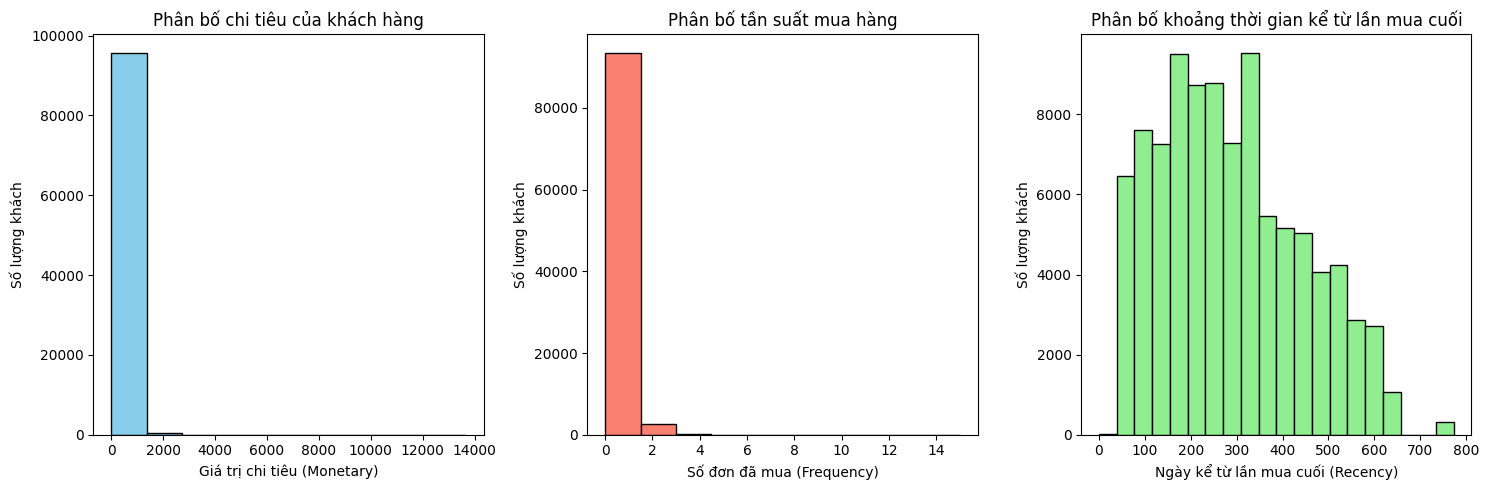

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)  # 1 hàng 3 cột, vị trí 1
plt.hist(df["monetary"], bins=10, color='skyblue', edgecolor='black')
plt.title("Phân bố chi tiêu của khách hàng")
plt.xlabel("Giá trị chi tiêu (Monetary)")
plt.ylabel("Số lượng khách")

plt.subplot(1, 3, 2)  # 1 hàng 3 cột, vị trí 2
plt.hist(df["frequency"], bins=10, color='salmon', edgecolor='black')
plt.title("Phân bố tần suất mua hàng")
plt.xlabel("Số đơn đã mua (Frequency)")
plt.ylabel("Số lượng khách")

plt.subplot(1, 3, 3)  # 1 hàng 3 cột, vị trí 3
plt.hist(df["recency"], bins=20, color='lightgreen', edgecolor='black')
plt.title("Phân bố khoảng thời gian kể từ lần mua cuối")
plt.xlabel("Ngày kể từ lần mua cuối (Recency)")
plt.ylabel("Số lượng khách")

plt.tight_layout()
plt.show();

**Nhận xét:**
- Có xuất hiện các giá trị ngoại lai ở Monetary và Frequency

#### Boxplot

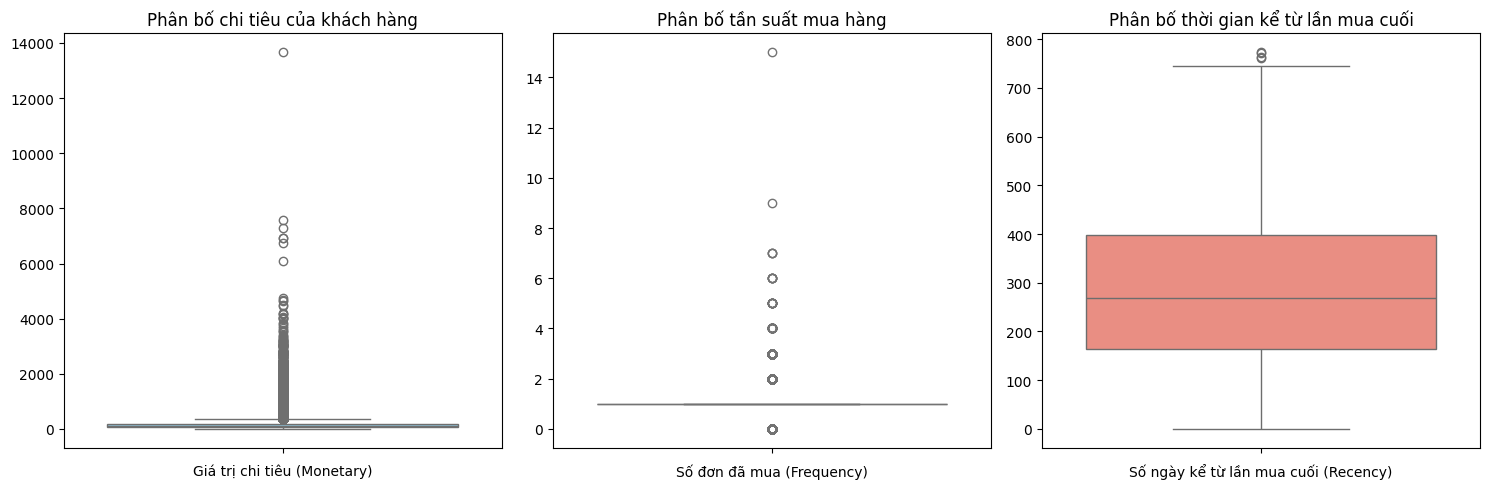

In [49]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)  # 1 hàng 3 cột, vị trí 1
sns.boxplot(df["monetary"], color='skyblue')
plt.title("Phân bố chi tiêu của khách hàng")
plt.xlabel("Giá trị chi tiêu (Monetary)")
plt.ylabel("") 

plt.subplot(1, 3, 2)  # 1 hàng 3 cột, vị trí 2
sns.boxplot(df["frequency"], color='lightgreen')
plt.title("Phân bố tần suất mua hàng")
plt.xlabel("Số đơn đã mua (Frequency)")
plt.ylabel("") 

plt.subplot(1, 3, 3)  # 1 hàng 3 cột, vị trí 3
sns.boxplot(df["recency"], color='salmon')
plt.title("Phân bố thời gian kể từ lần mua cuối")
plt.xlabel("Số ngày kể từ lần mua cuối (Recency)")
plt.ylabel("") 

plt.tight_layout()
plt.show()

**Nhận xét:**
- Monetary và Frequency không ổn cần lưu ý các giá trị ngoại lai
- Recency đã hợp lý

### 2.3 Tách dữ liệu có outlier và non-outlier

#### RFM có giá trị ngoại lai

In [50]:
M_Q1 = df["monetary"].quantile(0.25)
M_Q3 = df["monetary"].quantile(0.75)
M_IQR = M_Q3 - M_Q1


# Lấy outliers
monetary_outliers_df = df[(df["monetary"] < (M_Q1 - 1.5 * M_IQR)) | ((df["monetary"] > (M_Q3 + 1.5 * M_IQR)))].copy()
monetary_outliers_df.describe()

,recency,frequency,monetary
count,7573.000000,7573.000000,7573.000000
mean,286.731018,1.121352,700.695073
std,154.951709,0.461897,506.372837
min,48.000000,1.000000,357.120000
25%,160.000000,1.000000,417.020000
50%,266.000000,1.000000,539.370000
75%,395.000000,1.000000,783.000000
max,743.000000,15.000000,13664.080000


In [51]:
F_Q1 = df["frequency"].quantile(0.25)
F_Q3 = df["frequency"].quantile(0.75)
F_IQR = F_Q3 - F_Q1


# Lấy outliers
frequency_outliers_df = df[(df["frequency"] < (F_Q1 - 1.5 * F_IQR)) | ((df["frequency"] > (F_Q3 + 1.5 * F_IQR)))].copy()
frequency_outliers_df.describe()

,recency,frequency,monetary
count,5539.000000,5539.000000,5539.000000
mean,306.803033,1.068966,156.049325
std,161.684317,1.116026,273.145229
min,0.000000,0.000000,0.000000
25%,178.000000,0.000000,0.000000
50%,286.000000,2.000000,56.860000
75%,422.000000,2.000000,227.260000
max,773.000000,15.000000,7571.630000


**Nhận xét:**
- 

df ko có outlier

In [52]:
non_outliers_df = df[(~df.index.isin(monetary_outliers_df.index)) & (~df.index.isin(frequency_outliers_df.index))]
non_outliers_df.describe()

,recency,frequency,monetary
count,83699.000000,83699.0,83699.000000
mean,286.727344,1.0,116.107712
std,152.541296,0.0,73.535167
min,1.000000,1.0,0.000000
25%,163.000000,1.0,58.850000
50%,268.000000,1.0,97.710000
75%,395.500000,1.0,156.640000
max,762.000000,1.0,357.080000


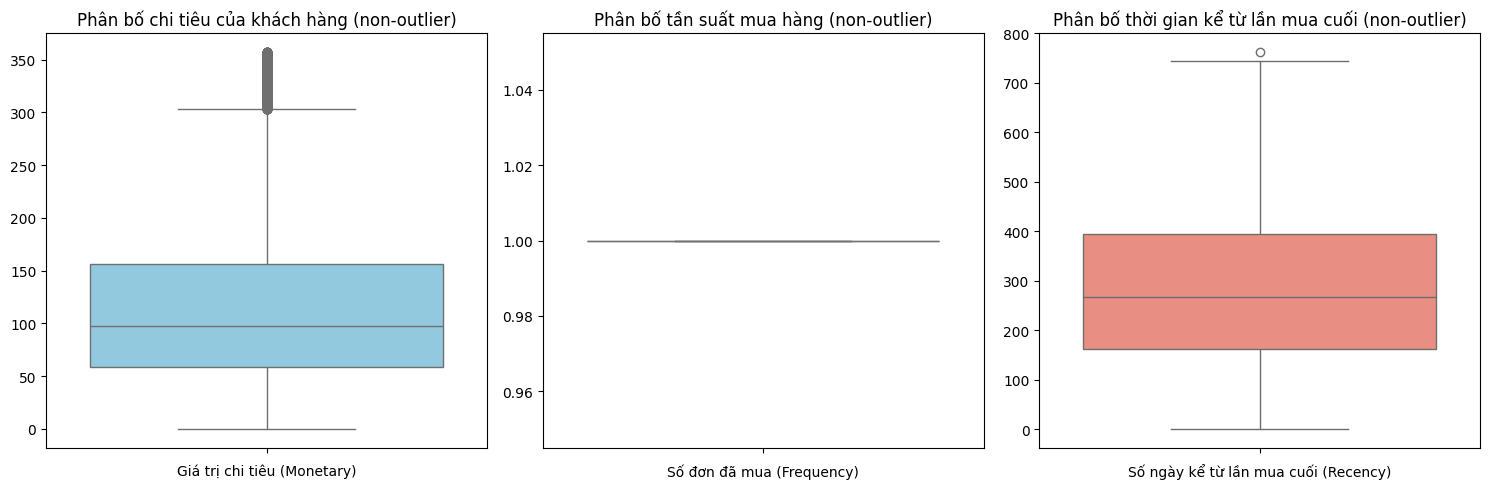

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)  # 1 hàng 3 cột, vị trí 1
sns.boxplot(non_outliers_df["monetary"], color='skyblue')
plt.title("Phân bố chi tiêu của khách hàng (non-outlier)")
plt.xlabel("Giá trị chi tiêu (Monetary)")
plt.ylabel("")

plt.subplot(1, 3, 2)  # 1 hàng 3 cột, vị trí 2
sns.boxplot(non_outliers_df["frequency"], color='lightgreen')
plt.title("Phân bố tần suất mua hàng (non-outlier)")
plt.xlabel("Số đơn đã mua (Frequency)")
plt.ylabel("")

plt.subplot(1, 3, 3)  # 1 hàng 3 cột, vị trí 3
sns.boxplot(non_outliers_df["recency"], color='salmon')
plt.title("Phân bố thời gian kể từ lần mua cuối (non-outlier)")
plt.xlabel("Số ngày kể từ lần mua cuối (Recency)")
plt.ylabel("")

plt.tight_layout()
plt.show()

In [54]:
non_outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83699 entries, 7573 to 93357
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  83699 non-null  object 
 1   recency             83699 non-null  int64  
 2   frequency           83699 non-null  int64  
 3   monetary            83699 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ MB


In [55]:
non_outliers_df["frequency"].value_counts()

frequency
1    83699
Name: count, dtype: int64

In [56]:
df["frequency"].value_counts()

frequency
1     90557
0      2738
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: count, dtype: int64

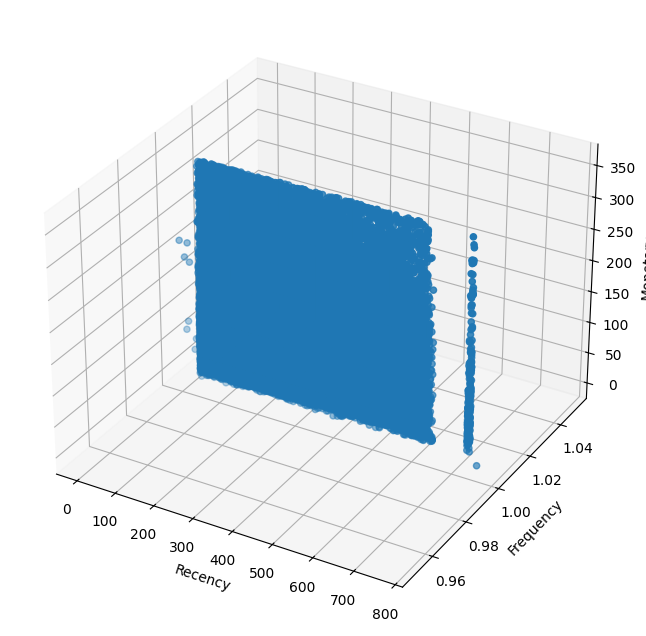

In [57]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(
    non_outliers_df["recency"],
    non_outliers_df["frequency"],
    non_outliers_df["monetary"],
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary') 

plt.show();

In [58]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_outliers_df[["recency", "frequency", "monetary"]])

In [59]:
scaled_data_df = pd.DataFrame(scaled_data, columns=["recency", "frequency", "monetary"])
scaled_data_df

,recency,frequency,monetary
0,1.031023,0.0,3.276986
1,-0.135881,0.0,3.276306
2,0.781909,0.0,3.276306
3,0.781909,0.0,3.276306
4,0.821243,0.0,3.276306
...,...,...,...
83694,0.808131,0.0,-1.420794
83695,-1.106116,0.0,-1.430857
83696,0.736019,0.0,-1.442009
83697,-1.532233,0.0,-1.448536


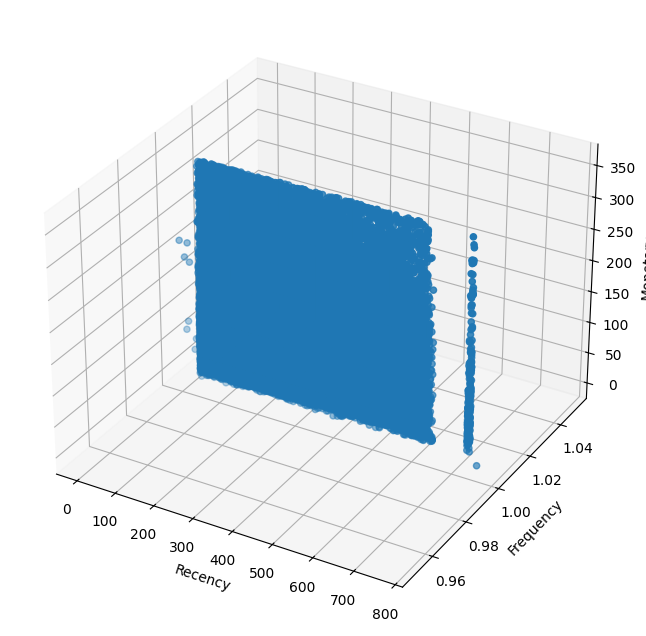

In [60]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(
    non_outliers_df["recency"],
    non_outliers_df["frequency"],
    non_outliers_df["monetary"],
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary') 

plt.show();

# K-Mean Clustering

In [ ]:
max_k = 12
silhouette_scores = []
inertia = []
k_values = range(2, max_k + 1)

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2000, max_iter=500)
    cluster_label = kmeans.fit_predict(scaled_data_df)
    
    # Chỉ tính silhouette trên 5000 mẫu ngẫu nhiên để giảm thời gian
    sample_idx = np.random.choice(len(scaled_data_df), 5000, replace=False)
    sil_score = silhouette_score(scaled_data_df.iloc[sample_idx], cluster_label[sample_idx])
    
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

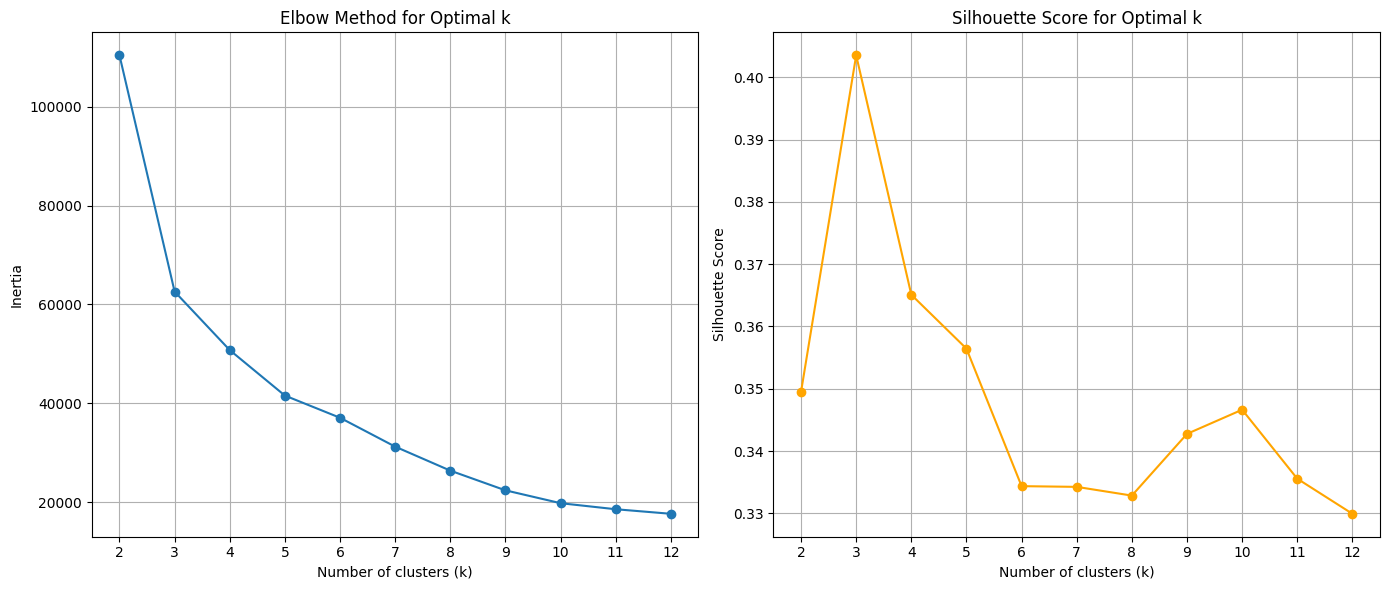

In [62]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values) # Hiển thị đủ giá trị trên trục x
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values) # Hiển thị đủ giá trị trên trục x
plt.grid(True)


plt.tight_layout()
plt.show();

Nên chọn $k=\mathbf{3}$.

$k=3$ là điểm khuỷu tay tốt nhất theo Inertia.

$k=3$ mang lại điểm Silhouette cao nhất.

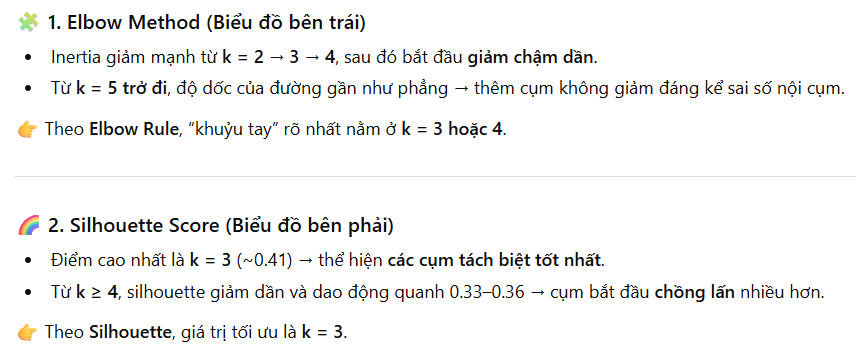

In [63]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([2, 2, 2, ..., 3, 0, 1], shape=(83699,), dtype=int32)

In [66]:
non_outliers_df["Cluster"] = cluster_labels
non_outliers_df

C:\Users\sonvuuu\AppData\Local\Temp\ipykernel_17688\1071184375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,customer_unique_id,recency,frequency,monetary,Cluster
7573,f2f42cdcf50f93b06b166895a3919f26,444,1,357.08,2
7575,8aa01aca756c6533618555d7195513fe,266,1,357.03,2
7576,cdf582422b69d4fbf906a9bb532089ce,406,1,357.03,2
7577,ac73a055ee14753b14b49a26db9dc7d9,406,1,357.03,2
7578,7a499f0679383d730d17aeb697b7addb,412,1,357.03,2
...,...,...,...,...,...
93353,6f5b9d1cdccc4d28f0483a612edecacf,410,1,11.63,3
93354,b33336f46234b24a613ad9064d13106d,118,1,10.89,0
93355,bd06ce0e06ad77a7f681f1a4960a3cc6,399,1,10.07,3
93356,317cfc692e3f86c45c95697c61c853a6,53,1,9.59,0


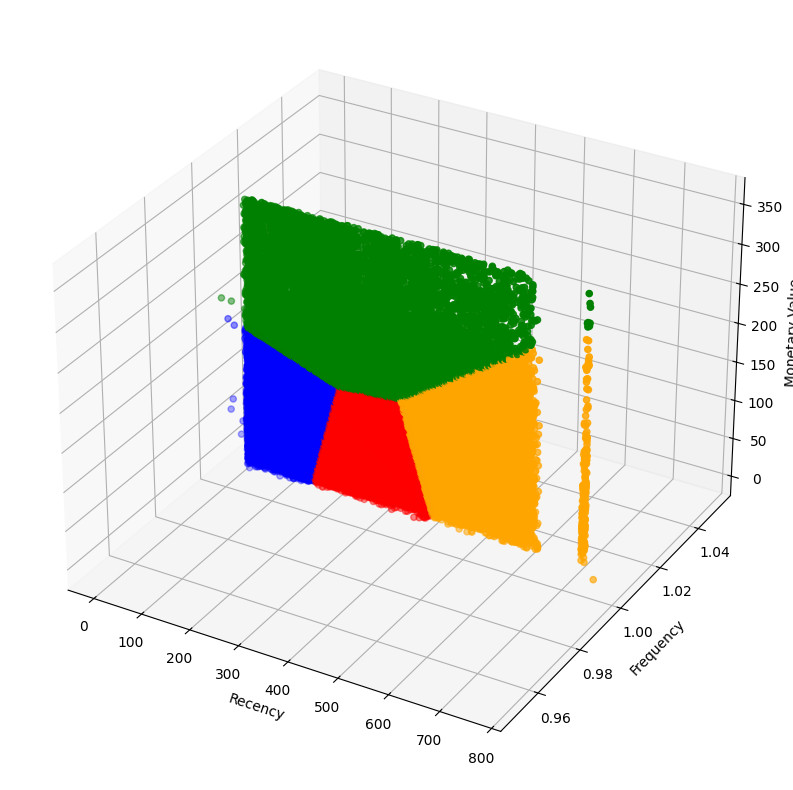

In [71]:
cluster_colors = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'red'
}

colors = non_outliers_df["Cluster"].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(
    non_outliers_df["recency"],
    non_outliers_df["frequency"],
    non_outliers_df["monetary"],
    c = colors,
    marker='o'
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value') 

plt.show();

# Analysis Non-outlier

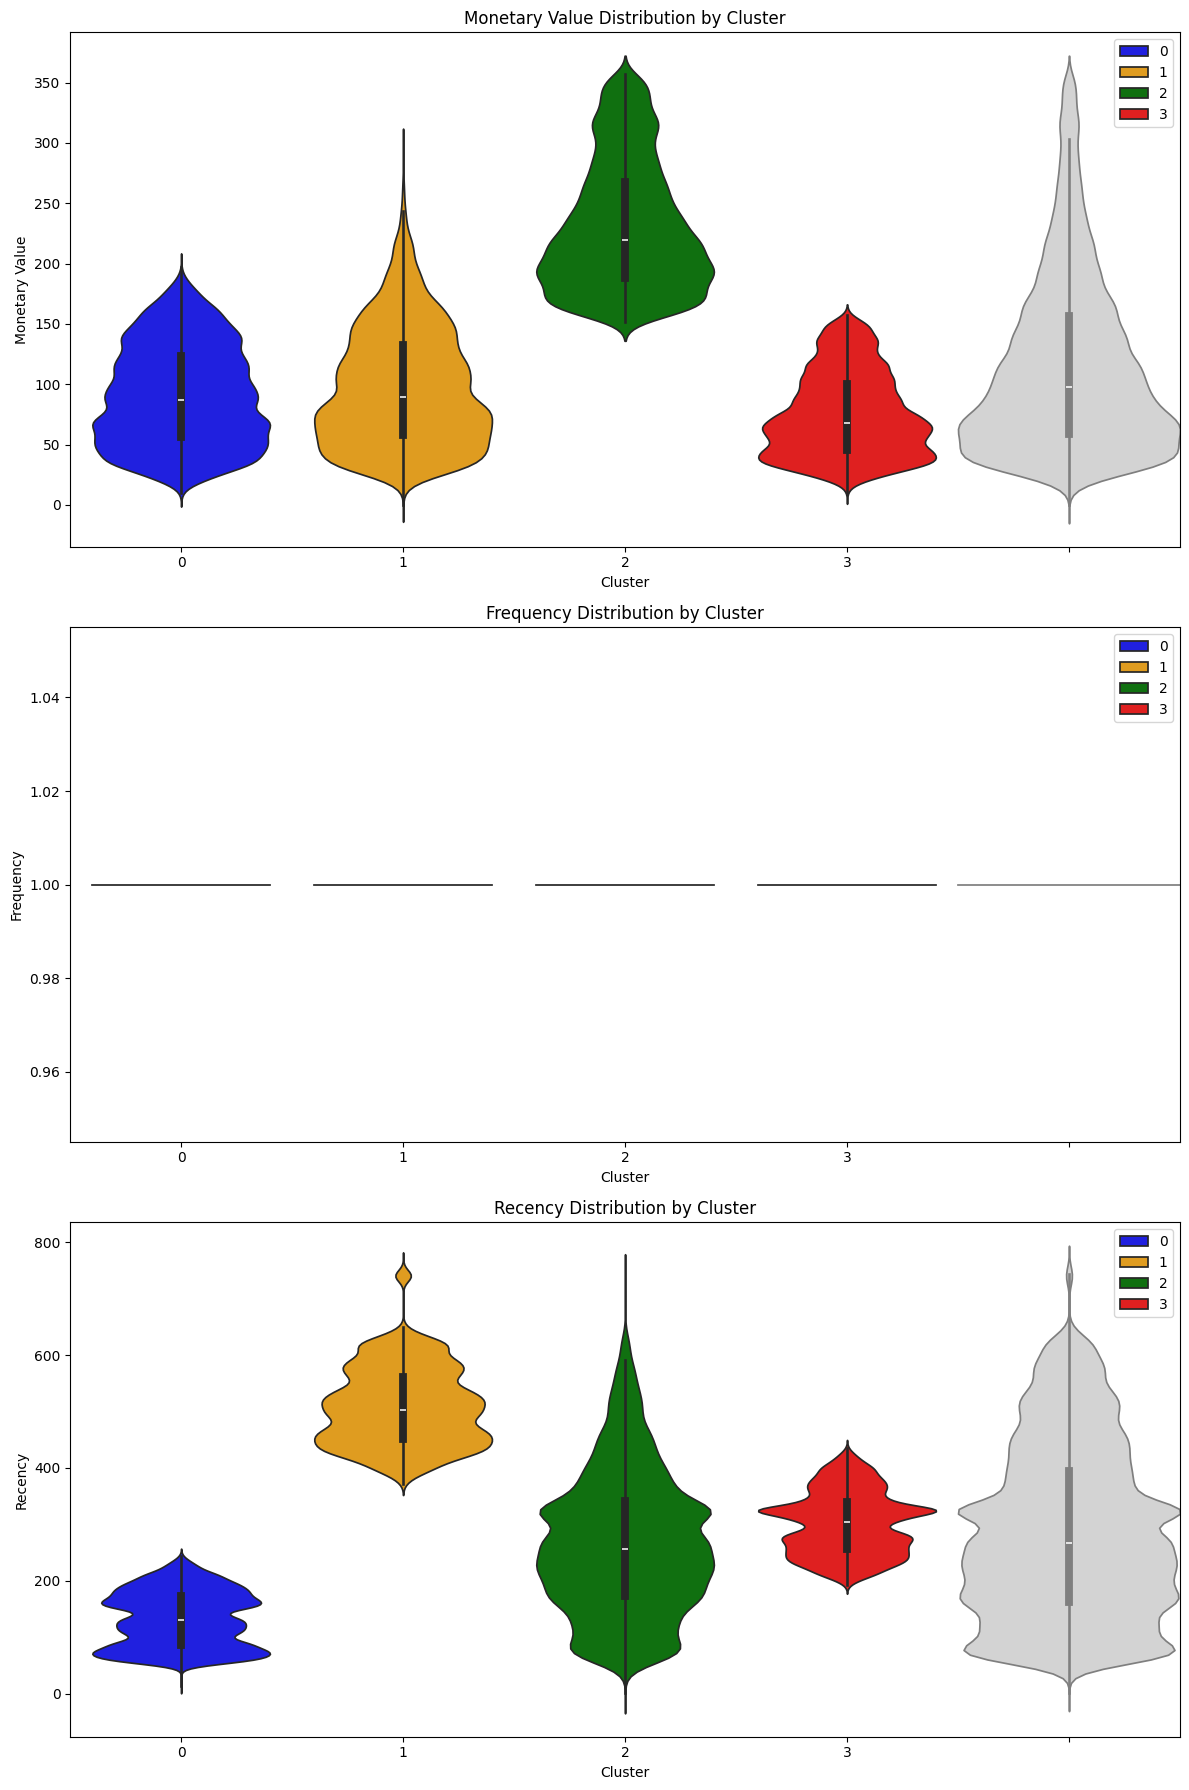

In [73]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["monetary"], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["monetary"], color='lightgray', width=1.0) # violinplot tổng thể
plt.title("Monetary Value Distribution by Cluster")
plt.ylabel("Monetary Value")
plt.xlabel("Cluster")

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["frequency"], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["frequency"], color='lightgray', width=1.0)
plt.title("Frequency Distribution by Cluster")
plt.ylabel("Frequency")

plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["recency"], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["recency"], color='lightgray', width=1.0)
plt.title("Recency Distribution by Cluster")
plt.ylabel("Recency")


plt.tight_layout()
plt.show();

### 🟦 Nhóm 1 – "Nurture"
- **Ý nghĩa:** Cụm này là những khách hàng vừa mới mua hàng (Recency thấp) nhưng giá trị đơn hàng không cao và cũng không thường xuyên mua hàng.  
- **Hành động:** Tập trung xây dựng mối quan hệ với khách hàng, cung cấp dịch vụ khách hàng tốt và khuyến mãi để khuyến khích mua thường xuyên hơn.

---

### 🟨 Nhóm 2 – "Re-engage"
- **Ý nghĩa:** Cụm này là những khách hàng chi tiêu trung bình thấp và đã không mua hàng trong một thời gian dài (Recency cao), cũng không thường xuyên mua hàng. Đây là nhóm có nguy cơ rời bỏ.  
- **Hành động:** Sử dụng chiến dịch marketing và ưu đãi giảm giá đặc biệt để thu hút họ quay lại.

---

### 🟩 Nhóm 3 – "High Value"
- **Ý nghĩa:** Đây là nhóm khách hàng chi tiêu nhiều nhất. Mặc dù thời gian mua trung bình thấp, nhưng họ có giá trị trọn đời (LTV) cao dù không mua thường xuyên.  
- **Hành động:** Duy trì mối quan hệ thân thiết, cung cấp ưu đãi VIP, chương trình khách hàng thân thiết và ưu tiên trải nghiệm cá nhân hóa.

---

### 🟥 Nhóm 4 – "Retain"
- **Ý nghĩa:** Họ đã mua hàng cách đây một thời gian (không quá mới, không quá cũ) nhưng chi tiêu thấp. Cần các chiến dịch để kích thích mua lại.  
- **Hành động:** Thực hiện remarketing, gửi thông báo sản phẩm mới hoặc flash sale để khuyến khích quay lại mua hàng.


# Analysis Outlier

In [75]:
monetary_outliers_df

,customer_unique_id,recency,frequency,monetary
0,0a0a92112bd4c708ca5fde585afaa872,383,1,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,564,2,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,94,1,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,612,1,6929.31
4,459bef486812aa25204be022145caa62,84,1,6922.21
...,...,...,...,...
7568,f818fa469aae778ea44fb1c8c1c7dbff,525,1,357.13
7569,7378e1df7887e19e853c88113e3885ec,541,1,357.13
7570,1e060fb5efaa80937d7b9377f9dd0da8,556,1,357.13
7571,0d30dfd90fc97a48ab2cd0b21b413950,602,1,357.13


In [ ]:
frequency_outliers_df

,customer_unique_id,recency,frequency,monetary
1,da122df9eeddfedc1dc1f5349a1a690c,564,2,7571.63
9,c8460e4251689ba205045f3ea17884a1,70,4,4655.91
24,59d66d72939bc9497e19d89c61a96d5f,433,2,3559.99
61,eae0a83d752b1dd32697e0e7b4221656,176,2,2783.01
90,d77aa95864ae5b42160937615628723a,414,2,2450.10
...,...,...,...,...
96091,b8b8726af116a5cfb35b0315ecef9172,744,0,0.00
96092,0eb1ee9dba87f5b36b4613a65074337c,745,0,0.00
96093,009b0127b727ab0ba422f6d9604487c7,764,0,0.00
96094,4854e9b3feff728c13ee5fc7d1547e92,772,0,0.00


In [77]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

# Lấy dữ liệu trùng cả 2 nhóm
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

# Sau đó loại bỏ khỏi 2 nhóm riêng
monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])
outlier_clusters_df

,customer_unique_id,recency,frequency,monetary,Cluster
0,0a0a92112bd4c708ca5fde585afaa872,383,1,13664.08,-1
2,763c8b1c9c68a0229c42c9fc6f662b93,94,1,7274.88,-1
3,dc4802a71eae9be1dd28f5d788ceb526,612,1,6929.31,-1
4,459bef486812aa25204be022145caa62,84,1,6922.21,-1
5,ff4159b92c40ebe40454e3e6a7c35ed6,511,1,6726.66,-1
...,...,...,...,...,...
7524,d7bf7cfe09c3d0f40e1cabde2dc17fd4,111,2,358.49,-3
7526,bf087cbc0138d7066e1c41d1a97973dd,111,2,358.44,-3
7541,f170c6e04c4cdf9219fc5c669b10f506,277,2,357.96,-3
7549,2e08911037fe7ec67377711eee1fdbf3,230,2,357.78,-3


In [78]:
print(len(monetary_and_frequency_outliers))
print(len(monetary_only_outliers))
print(len(frequency_only_outliers))

715
6858
4824


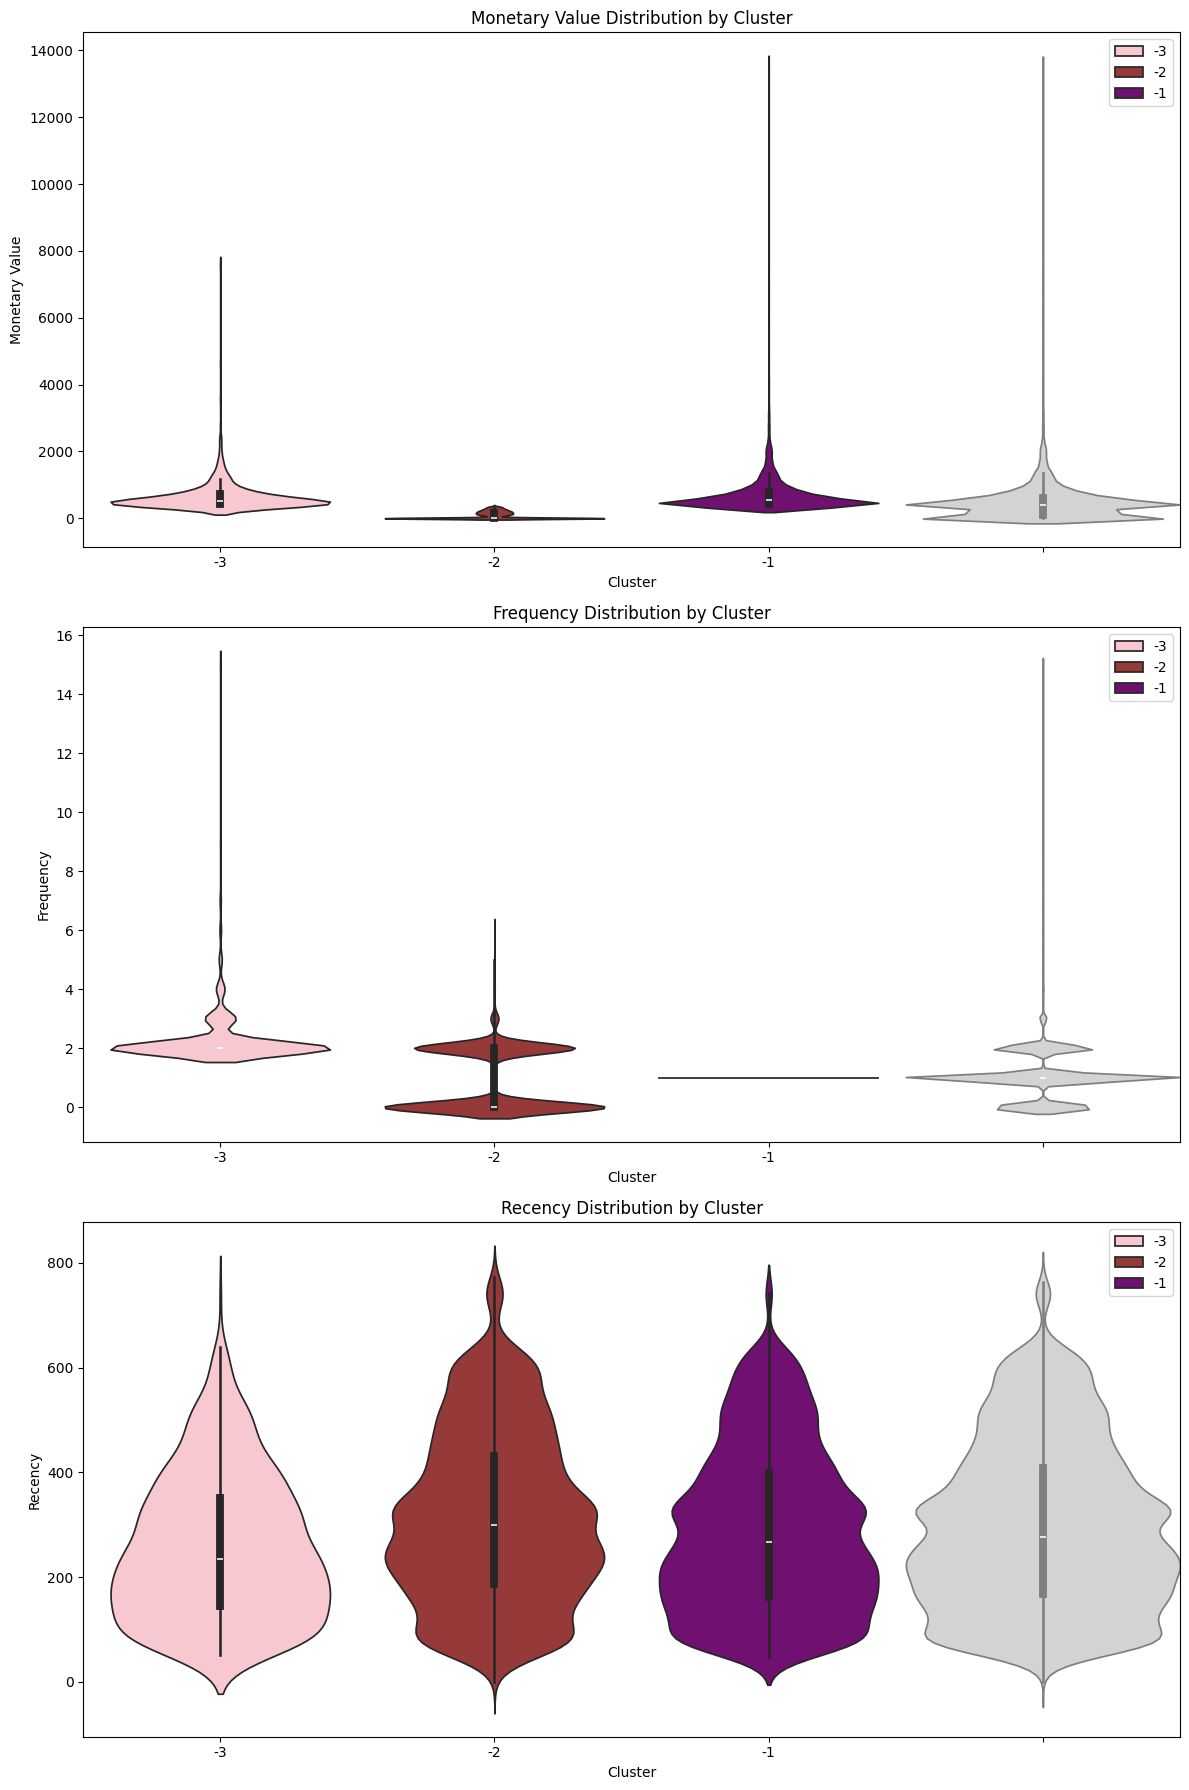

In [79]:
cluster_colors = {
    -3: 'pink',
    -2: 'brown',
    -1: 'purple',
}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df["Cluster"], y=outlier_clusters_df["monetary"], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df["monetary"], color='lightgray', width=1.0) # violinplot tổng thể
plt.title("Monetary Value Distribution by Cluster")
plt.ylabel("Monetary Value")
plt.xlabel("Cluster")

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df["Cluster"], y=outlier_clusters_df["frequency"], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df["frequency"], color='lightgray', width=1.0)
plt.title("Frequency Distribution by Cluster")
plt.ylabel("Frequency")

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df["Cluster"], y=outlier_clusters_df["recency"], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df["recency"], color='lightgray', width=1.0)
plt.title("Recency Distribution by Cluster")
plt.ylabel("Recency")


plt.tight_layout()
plt.show();

### 🟣 Nhóm -1 (Tím): **Pamper**
- **Ý nghĩa:** Nhóm có **Monetary cao nhất**, thể hiện đây là nhóm khách hàng **giá trị cao**. Tuy Frequency không quá lớn, nhưng họ chi tiêu nhiều mỗi lần mua và vẫn tương tác gần đây.  
- **Hành động:**  
  - Duy trì quan hệ, gửi ưu đãi VIP.  
  - Cung cấp chương trình khách hàng thân thiết, chăm sóc cá nhân hóa.  

---

### 🟤 Nhóm -2 (Nâu): **Upsell**
- **Ý nghĩa:** Có **Recency trung bình - cao**, **Frequency và Monetary thấp** → nhóm **nguy cơ rời bỏ**.  
- **Hành động:**  
  - Gửi email tái tương tác, ưu đãi giảm giá mạnh.  
  - Thực hiện chiến dịch remarketing hoặc winback.  

---

### 🌸 Nhóm -3 (Hồng nhạt): **Potential**
- **Ý nghĩa:** Có **Recency thấp (mới mua gần đây)**, **Frequency cao so với mặt bằng chung** và **Monetary thấp** → nhóm **khách hàng mới** cần được nuôi dưỡng.  
- **Hành động:**  
  - Gửi lời cảm ơn, đề xuất sản phẩm liên quan.  
  - Tặng mã giảm giá nhỏ để khuyến khích mua lại.

# Gán data

In [88]:
cluster_labels = {
    0: "NURTURE",
    1: "RE-ENGAGE",
    2: "HIGH-VALUE",
    3: "RETAIN",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "POTENTIAL",
}

In [89]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

In [90]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

# Visualize

C:\Users\sonvuuu\AppData\Local\Temp\ipykernel_17688\371242297.py:12: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=feature_means, markers="o", dashes=False, ax=ax2, palette='Set1')


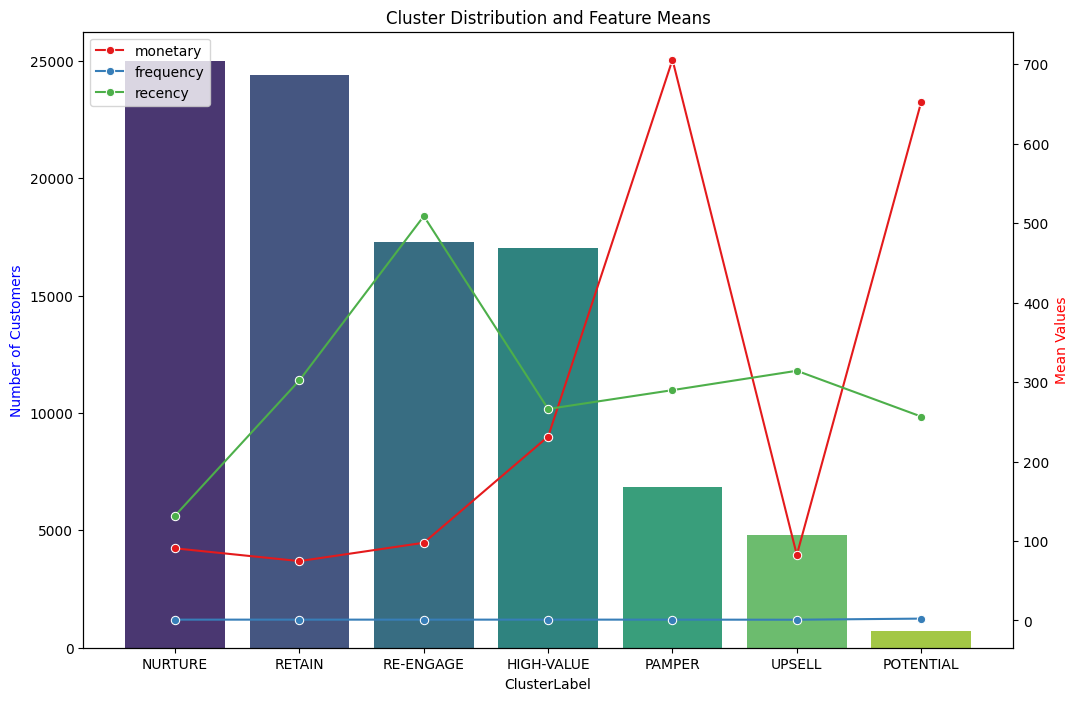

: 

In [ ]:
cluster_count = full_clustering_df["ClusterLabel"].value_counts()
feature_means = full_clustering_df.groupby("ClusterLabel")[["monetary", "frequency", "recency"]].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_count.index, y=cluster_count.values, ax=ax1, palette='viridis', hue=cluster_count.index)
ax1.set_ylabel("Number of Customers", color='blue')
ax1.set_title("Cluster Distribution and Feature Means")

ax2 = ax1.twinx() # tạo trục y thứ 2

sns.lineplot(data=feature_means, markers="o", dashes=False, ax=ax2, palette='Set1')
ax2.set_ylabel("Mean Values", color='red')

plt.show();